In [1]:
import psycopg2
from typing import Optional, TypedDict
from groq import Groq
from tabulate import tabulate
from langgraph.graph import StateGraph, END


In [2]:

groq_client = Groq(api_key="your api key")


In [3]:

class DatabaseManager:
    def __init__(self):
        conn_params = {
                "host": "localhost",
                "database": "postgres",
                "user": "postgres",  
                "password": "123456",
                "port": "5432"
                }
        self.conn = psycopg2.connect(**conn_params)
        self.conn.autocommit = True
    
    def get_schema(self) -> str:
        """Retrieve Pagila database schema"""
        schema = []
        with self.conn.cursor() as cursor:
            # Get tables
            cursor.execute("""
                SELECT table_name 
                FROM information_schema.tables 
                WHERE table_schema = 'public'
            """)
            tables = [row[0] for row in cursor.fetchall()]
            
            # Get columns for each table
            for table in tables:
                cursor.execute("""
                    SELECT column_name, data_type 
                    FROM information_schema.columns 
                    WHERE table_name = %s
                """, (table,))
                columns = cursor.fetchall()
                schema.append(f"Table {table}:\n" + "\n".join(
                    [f"- {col[0]} ({col[1]})" for col in columns]
                ))
        return "\n\n".join(schema)
    
    def execute_query(self, query: str) -> tuple:
        """Execute SQL query and return results"""
        try:
            with self.conn.cursor() as cursor:
                cursor.execute(query)
                if cursor.description:
                    columns = [desc[0] for desc in cursor.description]
                    results = cursor.fetchall()
                else:
                    columns = []
                    results = []
                return (True, results, columns)
        except Exception as e:
            return (False, None, str(e))


In [4]:

# Initialize database components
db_manager = DatabaseManager()
database_schema = db_manager.get_schema()


In [5]:

# state structure
class AgentState(TypedDict):
    natural_query: str
    generated_sql: Optional[str]
    results: Optional[list]
    columns: Optional[list]
    error: Optional[str]
    attempt_count: int

def generate_sql(state: AgentState) -> dict:
    """Generate SQL from natural language query using Groq"""
    prompt = f"""You are a PostgreSQL expert. Use the database schema:

{database_schema}

Convert this natural language query to SQL:
{state['natural_query']}

Rules:
- Use ONLY the provided schema
- Return valid PostgreSQL SQL
- Use explicit column names
- Include proper JOIN conditions
- Use LIMIT instead of TOP
- Use ILIKE for case-insensitive matches
- Handle date ranges properly

Respond ONLY with the SQL query. No explanations or formatting."""
    
    response = groq_client.chat.completions.create(
        messages=[{"role": "user", "content": prompt}],
        model="llama3-70b-8192",
        temperature=0.3,
        max_tokens=500
    )
    
    generated_sql = response.choices[0].message.content.strip()
    return {"generated_sql": generated_sql, "error": None}

def execute_sql(state: AgentState) -> dict:
    """Execute generated SQL query"""
    success, results, columns_or_error = db_manager.execute_query(state["generated_sql"])
    
    if success:
        return {
            "results": results,
            "columns": columns_or_error,
            "error": None,
            "attempt_count": state["attempt_count"] + 1
        }
    else:
        return {
            "error": columns_or_error,
            "results": None,
            "columns": None,
            "attempt_count": state["attempt_count"] + 1
        }

def handle_error(state: AgentState) -> dict:
    """Handle SQL errors and generate corrected query"""
    prompt = f"""Database Schema:
{database_schema}

Original Query Request:
{state['natural_query']}

Previous SQL Attempt:
{state['generated_sql']}

Error Message:
{state['error']}

Please:
1. Analyze the error
2. Generate corrected SQL
3. Ensure SQL follows SQLite syntax
4. Verify table/column names match schema

Respond ONLY with the corrected SQL query. No explanations or formatting."""
    
    response = groq_client.chat.completions.create(
        messages=[{"role": "user", "content": prompt}],
        model="llama3-70b-8192",
        temperature=0.3,
        max_tokens=500
    )
    
    corrected_sql = response.choices[0].message.content.strip()
    return {"generated_sql": corrected_sql, "error": None}

def display_results(state: AgentState) -> dict:
    """Format and display results"""
    print("\nQuery Results:")
    print(tabulate(state["results"], headers=state["columns"], tablefmt="grid"))
    return {"output": "Results displayed successfully"}

def handle_failure(state: AgentState) -> dict:
    """Handle final failure after max attempts"""
    print(f"\nFailed to generate valid SQL after {state['attempt_count']} attempts")
    print(f"Last error: {state['error']}")
    return {"output": "Execution failed"}

In [6]:

groq_client = Groq(api_key="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")


# Initialize database components
db_manager = DatabaseManager()
database_schema = db_manager.get_schema()

# state structure
class AgentState(TypedDict):
    natural_query: str
    generated_sql: Optional[str]
    results: Optional[list]
    columns: Optional[list]
    error: Optional[str]
    attempt_count: int

def generate_sql(state: AgentState) -> dict:
    """Generate SQL from natural language query using Groq"""
    prompt = f"""You are a PostgreSQL expert. Use the Pagila database schema:

{database_schema}

Convert this natural language query to SQL:
{state['natural_query']}

Rules:
- Use ONLY the provided schema
- Return valid PostgreSQL SQL
- Use explicit column names
- Include proper JOIN conditions
- Use LIMIT instead of TOP
- Use ILIKE for case-insensitive matches
- Handle date ranges properly

Respond ONLY with the SQL query. No explanations or formatting."""
    
    response = groq_client.chat.completions.create(
        messages=[{"role": "user", "content": prompt}],
        model="llama3-70b-8192",
        temperature=0.3,
        max_tokens=500
    )
    
    generated_sql = response.choices[0].message.content.strip()
    return {"generated_sql": generated_sql, "error": None}

def execute_sql(state: AgentState) -> dict:
    """Execute generated SQL query"""
    success, results, columns_or_error = db_manager.execute_query(state["generated_sql"])
    
    if success:
        print(f"\n {state['generated_sql']}\n")
        with open("output_query.txt", "a") as file:
            file.write(f"\n{state['generated_sql']}\n")
            
        return {
            "results": results,
            "columns": columns_or_error,
            "error": None,
            "attempt_count": state["attempt_count"] + 1
        }
    else:
        return {
            "error": columns_or_error,
            "results": None,
            "columns": None,
            "attempt_count": state["attempt_count"] + 1
        }

def handle_error(state: AgentState) -> dict:
    """Handle SQL errors and generate corrected query"""
    prompt = f"""Database Schema:
{database_schema}

Original Query Request:
{state['natural_query']}

Previous SQL Attempt:
{state['generated_sql']}

Error Message:
{state['error']}

Please:
1. Analyze the error
2. Generate corrected SQL
3. Ensure SQL follows SQLite syntax
4. Verify table/column names match schema

Respond ONLY with the corrected SQL query. No explanations or formatting."""
    
    response = groq_client.chat.completions.create(
        messages=[{"role": "user", "content": prompt}],
        model="llama3-70b-8192",
        temperature=0.3,
        max_tokens=500
    )
    
    corrected_sql = response.choices[0].message.content.strip()
    
    return {"generated_sql": corrected_sql, "error": None}

def display_results(state: AgentState) -> dict:
    """Format and display results"""
    print("\nQuery Results:")
    print(tabulate(state["results"], headers=state["columns"], tablefmt="grid"))
    return {"output": "Results displayed successfully"}

def handle_failure(state: AgentState) -> dict:
    """Handle final failure after max attempts"""
    print(f"\nFailed to generate valid SQL after {state['attempt_count']} attempts")
    print(f"Last error: {state['error']}")
    return {"output": "Execution failed"}

In [7]:
workflow = StateGraph(AgentState)

# Add nodes
workflow.add_node("generate_sql", generate_sql)
workflow.add_node("execute_sql", execute_sql)
workflow.add_node("handle_error", handle_error)
workflow.add_node("display_results", display_results)
workflow.add_node("handle_failure", handle_failure)

# Set initial point
workflow.set_entry_point("generate_sql")

# Add edges
workflow.add_edge("generate_sql", "execute_sql")
workflow.add_edge("display_results", END)
workflow.add_edge("handle_failure", END)

# Add conditional edges
def decide_next_step(state: AgentState) -> str:
    if state.get("error"):
        if state["attempt_count"] >= 3:
            return "handle_failure"
        return "handle_error"
    return "display_results"

workflow.add_conditional_edges(
    "execute_sql",
    decide_next_step,
    {
        "handle_error": "handle_error",
        "display_results": "display_results",
        "handle_failure": "handle_failure"
    }
)

workflow.add_conditional_edges(
    "handle_error",
    lambda state: "generate_sql",
    {"generate_sql": "generate_sql"}
)

app = workflow.compile() # compile the workflow

graph image

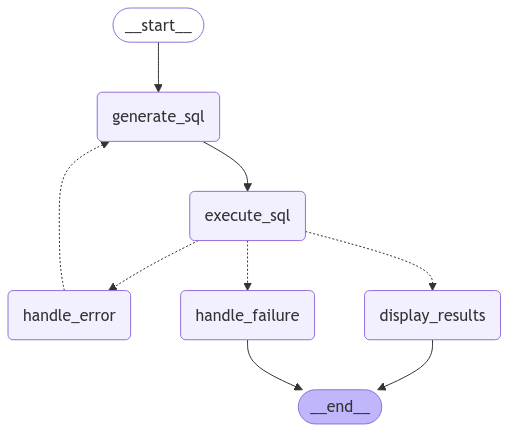

In [8]:
from IPython.display import display,Image

display(Image(app.get_graph().draw_mermaid_png()))

# example run

In [9]:
def run_query(natural_query: str):
    initial_state = {
        "natural_query": natural_query,
        "generated_sql": None,
        "results": None,
        "columns": None,
        "error": None,
        "attempt_count": 0
    }
    
    result = app.invoke(initial_state)
    return result


## Testing 

In [10]:
from tqdm import tqdm
queries = [
    "List all actors' first and last names.",
    "Show the titles of all films in the database.",
    "Get the names of all cities.",
    "List all categories available for films.",
    "Show the first name and last name of all customers.",
    "Show all films released in 2006.",
    'Find all actors with the last name "Smith."',
    'List all customers who are from the city of “New York.”',
    'Get all stores located in the country “India.”',
    "Show all films with a rental rate greater than $2.99.",
    "How many films are there in each category?",
    "What is the total number of actors?",
    "Get the total payment received in June 2022.",
    "Find the total number of rentals made last month.",
    'How many films have a rating of “PG-13”?',
    "List all films along with their category names.",
    'Show all actors who appeared in the film "Inception."',
    "Get a list of all customers and the films they have rented.",
    "List all staff members along with the stores they work at.",
    'Find all films rented by customer "John Doe."',
    "Show the top 5 films rented the most across all stores.",
    "List all customers who have rented films in both store 1 and store 2.",
    "Find all actors who have appeared in more than 10 films.",
    "Get a list of customers who have made more than 5 payments.",
    'List all films that are in both the "Action" and "Comedy" categories.',
    "Show all rentals made in the last 7 days.",
    "Get all payments made in February 2022.",
    "List all films that have not been rented in the last 30 days.",
    "Find all customers who registered in the last 6 months.",
    "Show all staff members hired before January 1, 2020.",
    "List the top 3 customers who have spent the most in each country.",
    "Find the films that have been rented more times than the average number of rentals per film.",
    "For each actor, show their name and the percentage of films they've acted in compared to the total films.",
    "Show the average payment amount for each customer.",
    "List all actors who have appeared in at least one film in each category.",
    "Find customers who have rented more films this year than last year.",
    "List the top 5 films with the highest revenue.",
    "For each customer, show the number of films rented in the last month compared to the previous month.",
    'Show the names of customers who have rented every film in the “Action” category.',
    "List customers who have rented the same film more than 3 times."
]

for query in queries:
    print(f"\nProcessing query: {query}")
    run_query(query)


Processing query: List all actors' first and last names.

 SELECT a.first_name, a.last_name 
FROM actor a;


Query Results:
+--------------+--------------+
| first_name   | last_name    |
+==============+==============+
| PENELOPE     | GUINESS      |
+--------------+--------------+
| NICK         | WAHLBERG     |
+--------------+--------------+
| ED           | CHASE        |
+--------------+--------------+
| JENNIFER     | DAVIS        |
+--------------+--------------+
| JOHNNY       | LOLLOBRIGIDA |
+--------------+--------------+
| BETTE        | NICHOLSON    |
+--------------+--------------+
| GRACE        | MOSTEL       |
+--------------+--------------+
| MATTHEW      | JOHANSSON    |
+--------------+--------------+
| JOE          | SWANK        |
+--------------+--------------+
| CHRISTIAN    | GABLE        |
+--------------+--------------+
| ZERO         | CAGE         |
+--------------+--------------+
| KARL         | BERRY        |
+--------------+--------------+
| UMA      